In [1]:
from pathlib import Path
from PIL import Image

from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, transforms, models

from tqdm.auto import tqdm

from timeit import default_timer as timer

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import random

In [2]:
warnings.filterwarnings("ignore")

In [3]:
print(f'The version of torch is : {torch.__version__}\nThe version of torchvision is : {torchvision.__version__}')

The version of torch is : 2.4.1+cu121
The version of torchvision is : 0.19.1+cu121


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
def check_directory(directory_path):                         
    for dirpath , dirname , filename in os.walk(directory_path):
        print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

In [6]:
d_train = "/kaggle/input/intel-image-classification/seg_train"
d_test = "/kaggle/input/intel-image-classification/seg_test"
d_pred = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"

train_dir = d_train + "/seg_train"
test_dir = d_test + "/seg_test"
prediction_dir = d_pred + "/seg_pred"

In [7]:
check_directory(Path(train_dir))

There are 6 directories and 0 images in '/kaggle/input/intel-image-classification/seg_train/seg_train'.
There are 0 directories and 2512 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/mountain'.
There are 0 directories and 2382 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/street'.
There are 0 directories and 2191 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/buildings'.
There are 0 directories and 2274 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/sea'.
There are 0 directories and 2271 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/forest'.
There are 0 directories and 2404 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/glacier'.


In [8]:
check_directory(Path(test_dir))

There are 6 directories and 0 images in '/kaggle/input/intel-image-classification/seg_test/seg_test'.
There are 0 directories and 525 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/mountain'.
There are 0 directories and 501 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/street'.
There are 0 directories and 437 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/buildings'.
There are 0 directories and 510 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/sea'.
There are 0 directories and 474 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/forest'.
There are 0 directories and 553 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/glacier'.


In [9]:
list_image_path = list(Path(train_dir).glob("*/*.jpg"))
random_image_path = random.choice(list_image_path)
img = Image.open(random_image_path)

In [10]:
print(f'The path   of the random image  is : {random_image_path}')
print(f'The class  of the random image  is : {random_image_path.parent.stem}')
print(f'The height of the random image  is : {img.height}')
print(f'The width  of the random image  is : {img.width}')

The path   of the random image  is : /kaggle/input/intel-image-classification/seg_train/seg_train/forest/10678.jpg
The class  of the random image  is : forest
The height of the random image  is : 150
The width  of the random image  is : 150


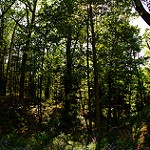

In [11]:
img

In [12]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(150 , 150)) ,
    transforms.ColorJitter(0.4,0.5,0.5,0.2),
    transforms.RandomHorizontalFlip(p=0.5) , 
    transforms.RandomCrop(size=(150,150)),  
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])


test_transforms = transforms.Compose([
    transforms.Resize((150, 150)), 
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.255, 0.245, 0.235))
])

In [13]:
def show_transformed_images(path , transform , number=4 ,seed = 42):
    random.seed = seed
    random_image = random.sample(path , number)
    
    for path in random_image:
        with Image.open(path) as f :
            fig , ax = plt.subplots(1,2)      
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {path.parent.stem}", fontsize=16)

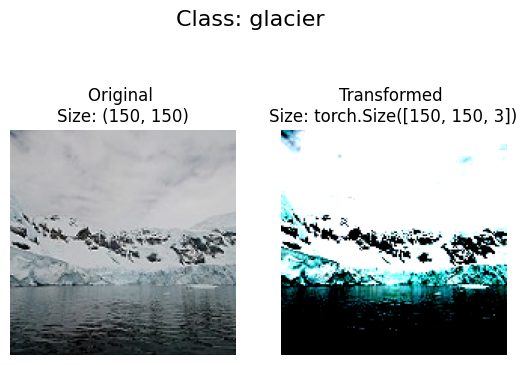

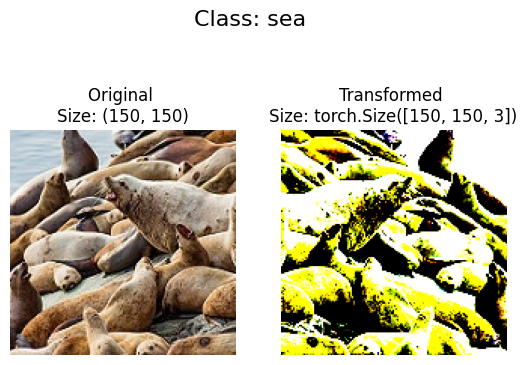

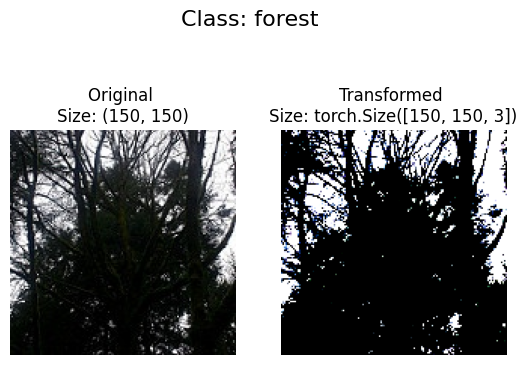

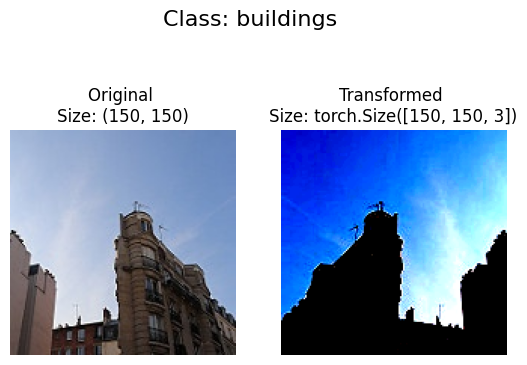

In [14]:
show_transformed_images(path=list_image_path , transform=train_transforms, number=4)

In [15]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)
print(f'Train data : {train_data}\n\n\nTest data : {test_data}')

Train data : Dataset ImageFolder
    Number of datapoints: 14034
    Root location: /kaggle/input/intel-image-classification/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ColorJitter(brightness=(0.6, 1.4), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.2, 0.2))
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(150, 150), padding=None)
               ToTensor()
               Normalize(mean=(0.425, 0.415, 0.405), std=(0.205, 0.205, 0.205))
           )


Test data : Dataset ImageFolder
    Number of datapoints: 3000
    Root location: /kaggle/input/intel-image-classification/seg_test/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.425, 0.415, 0.405), std=(0.255, 0.245, 0.235))
    

In [16]:
def class_finder(directory):
    classes = sorted(i.name for i in os.scandir(directory) if i.is_dir())

    if not classes:
        raise FileNotFound(f'This directory dose not have any classes : {directory}')

    class_to_inx = {name : value for name , value in enumerate(classes)}
    
    return classes, class_to_inx

In [17]:
class ImageFolderCustom(Dataset):
    def __init__(self, target_dir, transform):
        self.paths = list(Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.classes_to_inx = class_finder(target_dir)

    def load_image(self, index):
        image_path = self.paths[index]

        return Image.open(image_path)

    def __len__(self): return len(self.paths)

    def __getitem__(self, indx):
        img = self.load_image(indx)
        class_name = self.paths[indx].parent.name
        class_inx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx 
        else:
            return img, class_idx

In [18]:
train_data_custom = ImageFolderCustom(target_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir, transform=test_transforms)

In [19]:
print(f'The len of train data is : {len(train_data_custom)}\nThe len of test  data is : {len(test_data_custom)}')

The len of train data is : 14034
The len of test  data is : 3000


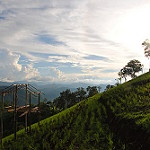

In [20]:
train_data_custom.load_image(10)

In [21]:
print(f'The number of classes are : {len(train_data_custom.classes)}')
train_data_custom.classes

The number of classes are : 6


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [22]:
train_data_custom.classes_to_inx

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [23]:
size_valid = 0.10

number_train = len(train_data_custom)
indx = list(range(number_train))

np.random.shuffle(indx)
split = int(size_valid * number_train)

train_idx, valid_idx = indx[split:], indx[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [24]:
train_dataloader = DataLoader(
    dataset=train_data , 
    batch_size=4 ,  
    num_workers=0,
    sampler=train_sampler  
)
                             
valid_dataloader = DataLoader(
    dataset=train_data, 
    batch_size=4, 
    num_workers=0,
    sampler=valid_sampler                            
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=4,
    num_workers=0,
    shuffle=False
)

In [25]:
img, label = next(iter(train_dataloader))
# img
print(f'The shape is : {img.shape} [batch-size , color-channels , height , width]')
print(f'The label shape is : {label.shape}')

The shape is : torch.Size([4, 3, 150, 150]) [batch-size , color-channels , height , width]
The label shape is : torch.Size([4])


In [26]:
# Models list
models_list = {
    "AlexNet": models.alexnet,
    "VGG16": models.vgg16,
    "ResNet50": models.resnet50
}

In [27]:
# Гиперпараметры
epochs = 50
criterion = nn.CrossEntropyLoss()

# Массив для хранения метрик
metrics = {}

In [28]:
metrics_folder = "/kaggle/working/metrics"
models_folder = "/kaggle/working/models"

folders = [metrics_folder, models_folder]

for folder in folders:
    # Check if the folder exists, and create it if it doesn't
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Folder '{folder}' created.")
    else:
        print(f"Folder '{folder}' already exists.")

Folder '/kaggle/working/metrics' created.
Folder '/kaggle/working/models' created.


In [29]:
for model_name, model_fn in models_list.items():
    print(f"\nTraining {model_name}...\n")
    
    # Инициализация модели
    model = model_fn(pretrained=True)
    
    # Заморозка весов предварительно обученной модели
    for param in model.parameters():
        param.requires_grad = False

    # Замена выходного слоя
    if hasattr(model, "fc"):  # Для моделей с полем fc (например, ResNet, Wide ResNet)
        number_features = model.fc.in_features
        model.fc = nn.Linear(in_features=number_features, out_features=len(train_data.classes))
    elif isinstance(model, models.SqueezeNet):  # Специфическая обработка для SqueezeNet
        number_features = model.classifier[1].in_channels
        model.classifier[1] = nn.Conv2d(
            in_channels=number_features,
            out_channels=len(train_data.classes),
            kernel_size=1
        )
        model.num_classes = len(train_data.classes)
    elif hasattr(model, "classifier"):  # Для моделей с полем classifier (например, AlexNet, VGG)
        if isinstance(model.classifier, nn.Sequential):
            number_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features=number_features, out_features=len(train_data.classes))
        else:
            number_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features=number_features, out_features=len(train_data.classes))
    else:
        raise ValueError("Модель не поддерживается или не распознана.")
    
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer=optimizer,
        milestones=[5, 10],
        gamma=0.555
    )
    
    # Метрики для текущей модели
    model_metrics = {"Train_loss": [], "Valid_loss": []}
    valid_loss_min = np.Inf
    
    st_time = timer()

    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0.0
        valid_loss = 0.0

        # Тренировка
        model.train()
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
        
        # Валидация
        model.eval()
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = criterion(y_pred, y)
                valid_loss += loss.item() * X.size(0)

        # Средние потери
        train_loss = train_loss / len(train_dataloader.sampler)
        valid_loss = valid_loss / len(valid_dataloader.sampler)
        model_metrics["Train_loss"].append(train_loss)
        model_metrics["Valid_loss"].append(valid_loss)

        # Шаг планировщика
        scheduler.step()

        # Лучшая модель
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), f"{models_folder}/{model_name}.pt")
            torch.save(model, f"{models_folder}/{model_name}_full.pt")
            valid_loss_min = valid_loss

        print(f"Epoch: {epoch}, Training Loss: {train_loss:.3f}, Validation Loss: {valid_loss:.3f}")

    end_time = timer()
    print(f"Training {model_name} completed in {end_time - st_time:.2f} seconds")
    
    # Сохранение метрик
    metrics[model_name] = model_metrics

    # Convert metrics to DataFrame
    df_metrics = pd.DataFrame(model_metrics)
    
    # Save metrics to CSV file with model name
    df_metrics.to_csv(f"{metrics_folder}/{model_name}_metrics.csv", index=False)
    print(f"Metrics for model {model_name} have been saved to {metrics_folder}/{model_name}_metrics.csv")


Training AlexNet...



Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 239MB/s] 


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.979, Validation Loss: 0.985
Epoch: 2, Training Loss: 1.072, Validation Loss: 1.074
Epoch: 3, Training Loss: 1.086, Validation Loss: 0.993
Epoch: 4, Training Loss: 1.114, Validation Loss: 1.057
Epoch: 5, Training Loss: 1.131, Validation Loss: 1.090
Epoch: 6, Training Loss: 0.903, Validation Loss: 0.945
Epoch: 7, Training Loss: 0.836, Validation Loss: 0.906
Epoch: 8, Training Loss: 0.816, Validation Loss: 0.953
Epoch: 9, Training Loss: 0.748, Validation Loss: 1.047
Epoch: 10, Training Loss: 0.757, Validation Loss: 0.944
Epoch: 11, Training Loss: 0.637, Validation Loss: 0.894
Epoch: 12, Training Loss: 0.648, Validation Loss: 0.906
Epoch: 13, Training Loss: 0.602, Validation Loss: 0.780
Epoch: 14, Training Loss: 0.590, Validation Loss: 0.725
Epoch: 15, Training Loss: 0.552, Validation Loss: 0.776
Epoch: 16, Training Loss: 0.544, Validation Loss: 0.829
Epoch: 17, Training Loss: 0.543, Validation Loss: 0.723
Epoch: 18, Training Loss: 0.542, Validation Loss: 0.771
E

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 221MB/s] 


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.612, Validation Loss: 0.457
Epoch: 2, Training Loss: 0.690, Validation Loss: 0.453
Epoch: 3, Training Loss: 0.720, Validation Loss: 0.532
Epoch: 4, Training Loss: 0.770, Validation Loss: 0.595
Epoch: 5, Training Loss: 0.792, Validation Loss: 0.534
Epoch: 6, Training Loss: 0.714, Validation Loss: 0.408
Epoch: 7, Training Loss: 0.658, Validation Loss: 0.518
Epoch: 8, Training Loss: 0.639, Validation Loss: 0.483
Epoch: 9, Training Loss: 0.601, Validation Loss: 0.418
Epoch: 10, Training Loss: 0.605, Validation Loss: 0.497
Epoch: 11, Training Loss: 0.574, Validation Loss: 0.440
Epoch: 12, Training Loss: 0.553, Validation Loss: 0.394
Epoch: 13, Training Loss: 0.508, Validation Loss: 0.400
Epoch: 14, Training Loss: 0.498, Validation Loss: 0.415
Epoch: 15, Training Loss: 0.468, Validation Loss: 0.436
Epoch: 16, Training Loss: 0.472, Validation Loss: 0.425
Epoch: 17, Training Loss: 0.470, Validation Loss: 0.398
Epoch: 18, Training Loss: 0.456, Validation Loss: 0.378
E

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s] 


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.844, Validation Loss: 0.426
Epoch: 2, Training Loss: 0.775, Validation Loss: 0.438
Epoch: 3, Training Loss: 0.745, Validation Loss: 0.451
Epoch: 4, Training Loss: 0.738, Validation Loss: 0.393
Epoch: 5, Training Loss: 0.730, Validation Loss: 0.356
Epoch: 6, Training Loss: 0.642, Validation Loss: 0.366
Epoch: 7, Training Loss: 0.632, Validation Loss: 0.360
Epoch: 8, Training Loss: 0.631, Validation Loss: 0.331
Epoch: 9, Training Loss: 0.620, Validation Loss: 0.347
Epoch: 10, Training Loss: 0.593, Validation Loss: 0.409
Epoch: 11, Training Loss: 0.549, Validation Loss: 0.360
Epoch: 12, Training Loss: 0.541, Validation Loss: 0.340
Epoch: 13, Training Loss: 0.558, Validation Loss: 0.399
Epoch: 14, Training Loss: 0.551, Validation Loss: 0.337
Epoch: 15, Training Loss: 0.549, Validation Loss: 0.391
Epoch: 16, Training Loss: 0.552, Validation Loss: 0.309
Epoch: 17, Training Loss: 0.542, Validation Loss: 0.359
Epoch: 18, Training Loss: 0.538, Validation Loss: 0.328
E

In [30]:
# Plot metrics
metrics_files = [f for f in os.listdir(metrics_folder) if f.endswith('.csv')]

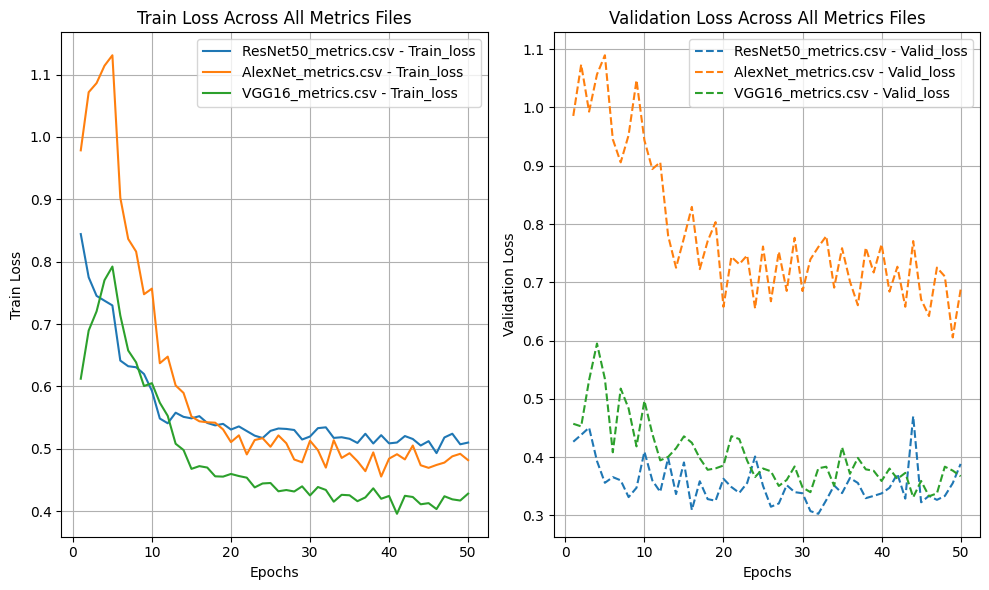

In [31]:
# Initialize the plots
plt.figure(figsize=(10, 6))

# Create a plot for Train Loss
plt.subplot(1, 2, 1)  # (rows, columns, index)
for csv_file in metrics_files:
    file_path = os.path.join(metrics_folder, csv_file)
    # Read the CSV file
    data = pd.read_csv(file_path)
    # Extract data
    epochs = range(1, len(data) + 1)
    train_loss = data['Train_loss']
    
    # Plot Train_loss
    plt.plot(epochs, train_loss, label=f'{csv_file} - Train_loss')

# Add labels and title for Train Loss
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Train Loss Across All Metrics Files')
plt.legend()
plt.grid(True)

# Create a plot for Validation Loss
plt.subplot(1, 2, 2)  # (rows, columns, index)
for csv_file in metrics_files:
    file_path = os.path.join(metrics_folder, csv_file)
    # Read the CSV file
    data = pd.read_csv(file_path)
    # Extract data
    epochs = range(1, len(data) + 1)
    valid_loss = data['Valid_loss']
    
    # Plot Valid_loss
    plt.plot(epochs, valid_loss, linestyle='--', label=f'{csv_file} - Valid_loss')

# Add labels and title for Validation Loss
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Across All Metrics Files')
plt.legend()
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [32]:
!zip -r models.zip /kaggle/working/models
!zip -r metrics.zip /kaggle/working/metrics

  adding: kaggle/working/models/ (stored 0%)
  adding: kaggle/working/models/AlexNet_full.pt (deflated 7%)
  adding: kaggle/working/models/VGG16_full.pt (deflated 7%)
  adding: kaggle/working/models/ResNet50.pt (deflated 7%)
  adding: kaggle/working/models/AlexNet.pt (deflated 7%)
  adding: kaggle/working/models/ResNet50_full.pt (deflated 7%)
  adding: kaggle/working/models/VGG16.pt (deflated 7%)
  adding: kaggle/working/metrics/ (stored 0%)
  adding: kaggle/working/metrics/ResNet50_metrics.csv (deflated 51%)
  adding: kaggle/working/metrics/AlexNet_metrics.csv (deflated 50%)
  adding: kaggle/working/metrics/VGG16_metrics.csv (deflated 51%)
